# Neurodynamics - Homework 05: The Izhikevich Model of Spiking Neurons

Group: Katarzyna Olszynska (1000023) & Benjamin Peters (982981)

## Imports

In [ ]:
!pip install brian2

In [ ]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt

## Question 1

We are looking at the Izhikevich model as presented in the original publication:

$\dot{V} = 0.04V^2 + 5V + 140 - u + I$

$\dot{u} = a(bV - u)$

if $V \ge 30$, then $V \gets c$ and $u \gets u + d$

with four parameters $a$, $b$, $c$ and $d$. Here, we are treating the entire equation as dimensionless, even though the specific coefficient form is chosen so that $V$ is in a typical range for real membrane potentials.

Make sure that you can solve the system in *brian2* given a set of parameters, an initial condition, and a step current $I$.

Next, also make sure that you can plot the model's nullclines in a phase portrait.

### Solution

In [ ]:
def simulate_izhikevich(time_span, V_0, params, input_current):
  """
  This function describes the simulation of neural spiking behaviour according to the Izhikevich model.

  Parameters:
  time_span -- denotes the length of the simulation
  V_0 -- the starting value for the membrane potential V
  params -- a tuple of model parameters a, b, c, and d
  input_current -- the step current that will be applied to the model neuron

  Returns:
  statemon -- a StateMonitor object tracking the behaviour of V(t) and u(t)
  """
  start_scope()

  # unpack model parameters
  a, b, c, d = params

  # create step current array
  timing_array = np.zeros(int(time_span/ms))
  timing_array[10:] = input_current
  step_current = TimedArray(timing_array, dt = 1*ms)

  # define the differential equations for the Izhikevich model
  eqs = """
  dV/dt = 1/ms * (0.04*V**2 + 5*V + 140 - u + I) : 1
  du/dt = a/ms * (b*V - u) : 1
  I = step_current(t) : 1
  """

  # describe conditions for spike cutoff and reset
  cutoff = "V >= 30"
  reset = "V = c; u += d"

  # create a NeuronGroup with respective spiking behaviour and starting values
  neuron = NeuronGroup(1, model=eqs, threshold=cutoff, reset=reset, method="euler")
  neuron.V = V_0
  neuron.u = b*V_0

  # set up a StateMonitor to track the trajectories of V(t) and u(t)
  statemon = StateMonitor(neuron, ["V", "u", "I"], record=True)

  # create a Network object to manage the simulation
  net = Network(neuron, statemon)
  # run a simulation for given duration
  net.run(time_span)

  return statemon

**Nullcline for $V$:**

$\dot{V} = 0.04V^2 + 5V + 140 - u + I = 0 \\ \Leftrightarrow u = 0.04V^2 + 5V + 140 + I$

**Nullcline for $u$:**

$\dot{u} = a(bV - u) = 0 \\ \Leftrightarrow u = bV$

In [ ]:
# define lambda functions for calculation of derivatives
dV = lambda V, u, I, c: 0.04*V**2 + 5*V + 140 - u + I if V < 30 else c
du = lambda V, u, a, b, d: a * (b*V - u) if V < 30 else u + d

# define lambda functions for nullcline calculation
V_nullcline = lambda V, I: 0.04*V**2 + 5*V + 140 + I
u_nullcline = lambda V, b: b*V

## Question 2

For each of the following parameterisations: plot the nullclines in the phase plane, then

* Simulate for 300ms, switching on the step current to the specified value at $t$ = 10ms for the rest of the experiment. The starting value for $V$ will be given, the starting value for $u$ is the asymptotic $u_o = b ∗ V$ .
* Plot the trace of $V$ over time.
* For up to a maximum of three spikes, plot the trajectories in phase space.

Here are the four parameter sets to look at:

1. $a = 0.02,$ $b = 0.2,$ $c = −65,$ $d = 6,$ with $V_0 = −70$ and the applied current $I = 14$
2. $a = 0.02,$ $b = 0.25,$ $c = −65,$ $d = 6,$ with $V_0 = −64$ and the applied current $I = 0.5$
3. $a = 0.02,$ $b = 0.2,$ $c = −50,$ $d = 2,$ with $V_0 = −70$ and the applied current $I = 15$
4. $a = 0.02,$ $b = 0.25,$ $c = −55,$ $d = 0.05,$ with $V_0 = −64$ and the applied current $I = 0.6$

Describe the qualitative differences in spiking behavior for each case, and how they are reflected in phase space.

### Solution

In [ ]:
# we simulate for 300ms
duration = 300*ms

# define the parameter sets for the model simulations
config_1 = [-70, (0.02, 0.2, -65, 6), 14]
config_2 = [-64, (0.02, 0.25, -65, 6), 0.5]
config_3 = [-70, (0.02, 0.2, -50, 2), 15]
config_4 = [-64, (0.02, 0.25, -55, 0.05), 0.6]

In [ ]:
def model(time_span, config):
  """
  This function runs the model simulation and illustrates its results.
  Returns a plot containing the development of V(t) and u(t) as well as the phase portrait.

  Parameters:
  time_span -- denotes the length of the simulation
  config -- a list of model parameters in the form [V_0, (a, b, c, d), I]
  """
  # unpack parameter configuration
  V_0, (a, b, c, d), I = config

  # run the model simulation
  stm = simulate_izhikevich(time_span, *config)

  # calculate nullclines within a plausible range for V
  V_range = np.linspace(-80, 45, 200)
  V_nc = [V_nullcline(v, I) for v in V_range]
  u_nc = [u_nullcline(v, b) for v in V_range]

  # create a mesh of evenly spaced vectors
  x = np.linspace(-80, 45, 20)
  y = np.linspace(-20, 10, 20)
  V_vals, u_vals = np.meshgrid(x, y)

  # calculate the vector field for V and u
  V_dir = np.array([dV(x_val, y_val, I, c) for y_val in y for x_val in x])
  u_dir = np.array([du(x_val, y_val, a, b, d) for y_val in y for x_val in x])

  fig, axes = plt.subplots(nrows=2, figsize=(8,10), gridspec_kw={'height_ratios': [1, 2]})

  # plot the development of the membrane potential V
  axes[0].plot(stm.t/ms, stm.V[0], color="royalblue", label="V")
  axes[0].plot(stm.t/ms, stm.u[0], color="darkorange", label="u")
  axes[0].set(title="Development of V(t) and u(t)", xlim=[0,int(time_span/ms)], ylim=[-80, 35], xlabel="Time (ms)", ylabel="State variables")
  axes[0].legend(loc="upper right")

  # plot the phase portrait
  # plot the nullclines
  axes[1].plot(V_range, V_nc, color="royalblue", label="V-nullcline")
  axes[1].plot(V_range, u_nc, color="darkorange", label="u-nullcline")
  # plot the phase plane
  axes[1].quiver(V_vals, u_vals, V_dir, u_dir, np.sqrt(V_dir**2 + u_dir**2), color="teal", label="Phase plane")
  # plot the trajectories of V(t) and u(t)
  axes[1].plot(stm.V[0], stm.u[0], color="forestgreen", label="V-u trajectory")
  # plot the spike cutoff
  axes[1].axvline(30, linestyle="--", color="maroon", label="Spike cutoff")

  axes[1].legend(loc="upper right")
  axes[1].set(title="Phase portrait of the system", xlim=[-80, 45], ylim=[-20, 10], xlabel="Membrane voltage (V)", ylabel="Recovery variable (u)")

  fig.suptitle(f"Izhikevich model simulation using these parameters: \n $a$ = {a}, $b$ = {b}, $c$ = {c}, $d$ = {d}, $V_0$ = {V_0}, $I$ = {I}")

  plt.show()

#### First configuration

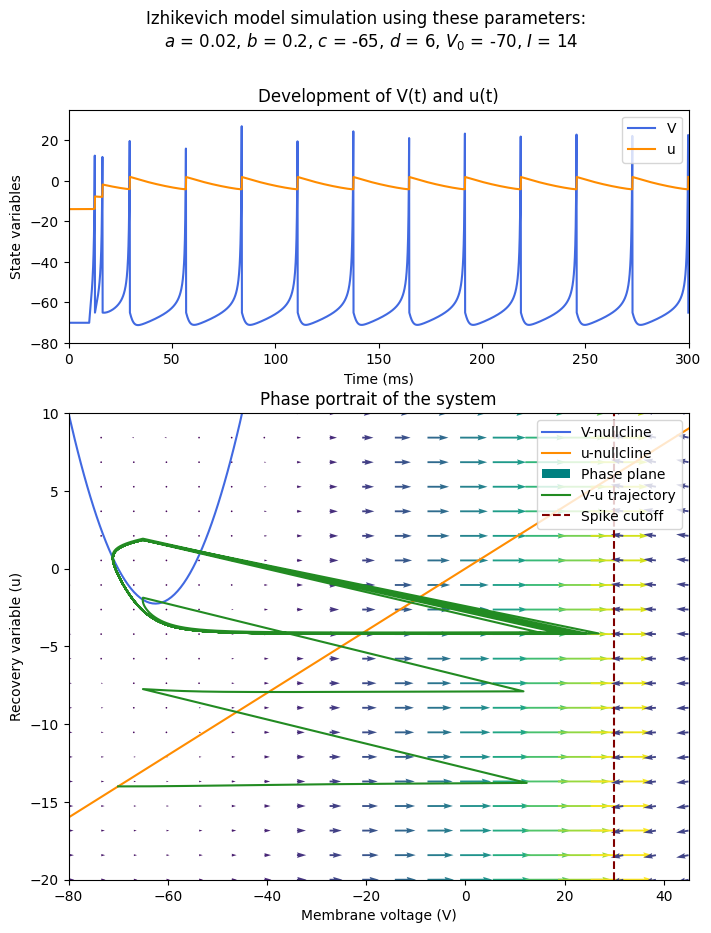

In [ ]:
model(duration, config_1)

Using this parameterization, the neuron exhibits tonic spiking. This means that after an initial burst, the neuron fires repetitively in regular intervals.

In the phase plane, the initial burst results in an increase of the recovery variable $u$ after each spike. Once it crosses a certain threshold, the system produces periodic orbits. These limit cycles in the phase plane explain the tonic spiking behaviour.

Since the nullclines do not intersect, the system does not have a stable or unstable node. Instead, $V_{nc} = u_{nc}$ only has complex solutions.

#### Second configuration

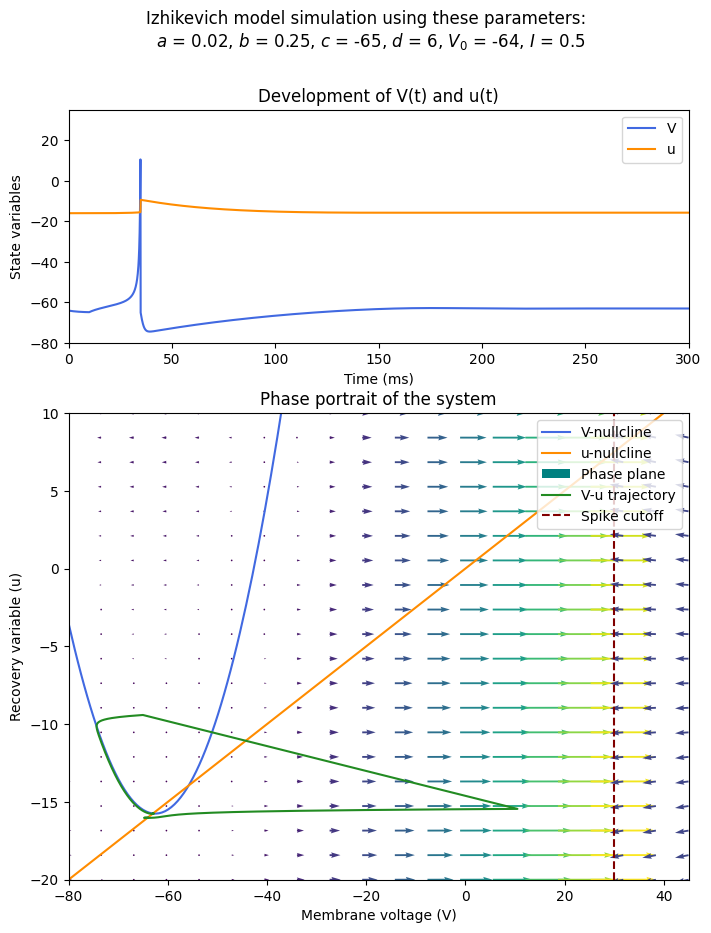

In [ ]:
model(duration, config_2)

Compared to the first configuration, this simulation applies a smaller current to the neuron. As a result, the neuron only shows phasic spiking. In this case, the model neuron only fires once.

The system has two fixed points: a stable one at circa $(-63,-16)$ and an unstable fixed point at roughly $(-56,-14)$. The phase plane drives the membrane voltage in the positive direction, implying a spike. After the hyperpolarization phase, the system gets into the attraction domain of the stable fixed point, where it finally ends up at an equilibrium. The stable fixed point therefore denotes the resting state of the neuron.

#### Third configuration

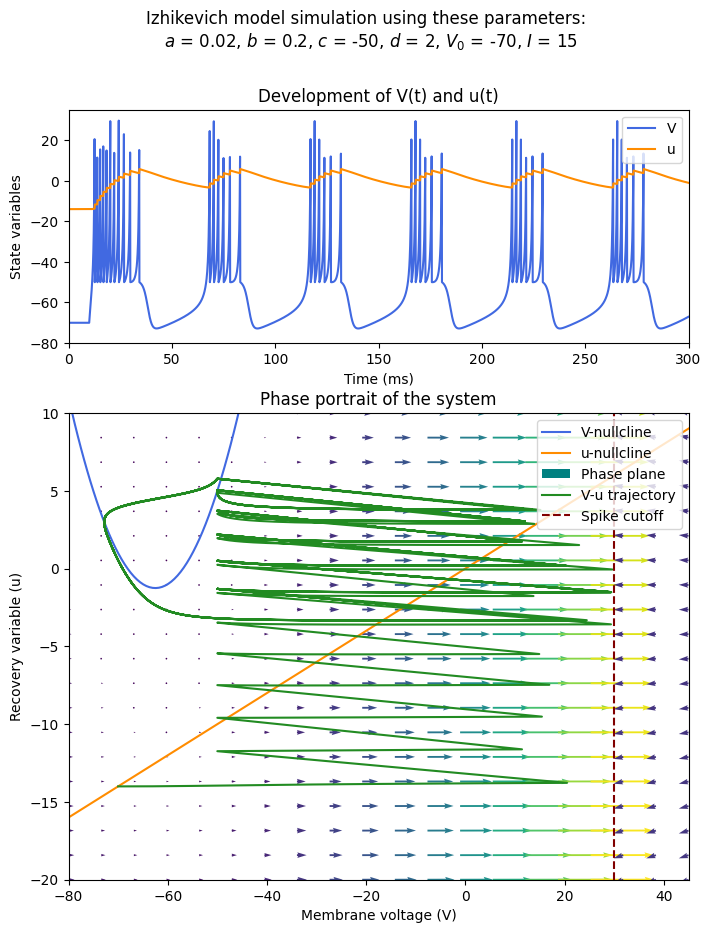

In [ ]:
model(duration, config_3)

By increasing the voltage reset variable $c$ while using a similar current as in the first experiment, the neuron is able to exhibit tonic bursting.

Similar to the first configuration, the system ends up showing a cyclic behaviour after an initial burst following the application of the step current. However, here the cycle is not restricted to only one spike, but rather the neuron fires repeatedly before $u$ reaches its maximum and the neuron hyperpolarizes further until spiking is resumed.

Again, $V_{nc} = u_{nc}$ only produces complex solutions.

#### Fourth configuration

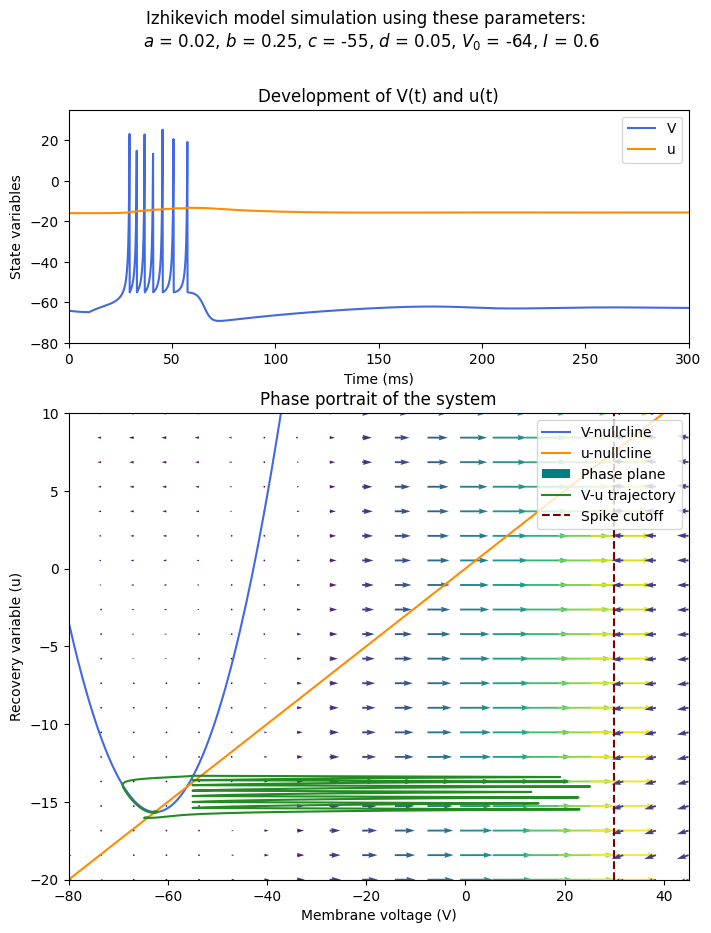

In [ ]:
model(duration, config_4)

In the final parameterization of the model simulation, the model neuron shows phasic bursting.

The procedure is similar to the second configuration. Here, it is a bursting behaviour that drives the system into the attraction domain of the stable fixed point. Subsequently, the system reaches an equilibrium that denotes the resting state of the neuron.

